In [1]:
BUCKET='hohukelkazan'

# Prepare

以下の流れはベイズ分類の時と変わらない

1. トレーニング日に関するデータのcsvの読み込み(スキーマ: header)
2. 読み込んだトレーニング日に関するデータをSpark SQLビューに変換
3. 飛行データのスキーマ定義
4. 飛行データのcsvの読み込み(スキーマ: 3で読み込んだやつ)
5. 読み込んだ飛行データをSpark SQLビューに変換
6. 2,5の結果をjoinさせてトレーニングデータ作成


In [2]:
# read
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

In [3]:
# Spark SQLビューに変換
traindays.createOrReplaceTempView('traindays')

In [4]:
# スキーマ定義(TAXI_OUTも数値型にする)
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
  if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
    return StructField(colname, FloatType(), True)
  else:
    return StructField(colname, StringType(), True)
  
schema = StructType([get_structfield(colname) for colname in header.split(',')])
print(schema)

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,FloatType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true),

In [5]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)
flights_csv = spark.read\
            .schema(schema)\
            .csv(inputs)
# tmpビュー作成
flights_csv.createOrReplaceTempView('flights')

In [6]:
# create train data
traindayquery = """
select
  f.DEP_DELAY, f.TAXI_OUT, f.ARR_DELAY, f.DISTANCE
from flights f
join traindays t
on f.FL_DATE == t.FL_DATE
where
  t.is_train_day == 'True'
"""
traindata = spark.sql(traindayquery)

In [7]:
# describe()メソッドは列ごとの統計情報を計算して、show()はその結果を表示するよ
# NULLはカウントしないからcountに差がでるよ(ex. スケジュールされたけど出発しなかった場合など)
traindata.describe().show()

+-------+------------------+------------------+-------------------+------------------+
|summary|         DEP_DELAY|          TAXI_OUT|          ARR_DELAY|          DISTANCE|
+-------+------------------+------------------+-------------------+------------------+
|  count|             11499|             11499|              11490|             11539|
|   mean| 3.454648230280894|13.642751543612489|-1.5182767624020888| 730.1944709246902|
| stddev|25.740781844738905| 7.044835806796173| 27.699119928843288|505.97999949572187|
|    min|             -20.0|               3.0|              -49.0|              67.0|
|    max|            1120.0|             136.0|             1116.0|            4983.0|
+-------+------------------+------------------+-------------------+------------------+



In [8]:
traindayquery = """
select
  f.DEP_DELAY, f.TAXI_OUT, f.ARR_DELAY, f.DISTANCE
from flights f
join traindays t
on f.FL_DATE == t.FL_DATE
where
  t.is_train_day == 'True' and
  f.cancelled == '0.00' and
  f.diverted == '0.00'
"""
traindata = spark.sql(traindayquery)
traindata.describe().show()

+-------+------------------+------------------+-------------------+------------------+
|summary|         DEP_DELAY|          TAXI_OUT|          ARR_DELAY|          DISTANCE|
+-------+------------------+------------------+-------------------+------------------+
|  count|             11490|             11490|              11490|             11490|
|   mean| 3.439947780678851|13.639773716275021|-1.5182767624020888| 731.1500435161009|
| stddev|25.697773876473068| 7.044639774520781| 27.699119928843288|506.55018097865286|
|    min|             -20.0|               3.0|              -49.0|              67.0|
|    max|            1120.0|             136.0|             1116.0|            4983.0|
+-------+------------------+------------------+-------------------+------------------+



 -> **COUNTに差が出なくなった**

# トレーニング

トレーニングデータの各レコードは、LabeldedPointクラスに変換する必要がある
- https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/classification/LogisticRegressionModel.html

**Label**
- on-timeである確率を予測！

In [9]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [10]:
def to_example(fields):
  return LabeledPoint(\
           float(fields['ARR_DELAY'] < 15), # on-time? \
           [\
             fields['DEP_DELAY'], \
             fields['TAXI_OUT'], \
             fields['DISTANCE'], \
           ])

In [11]:
# トレーニング用のラベルと入力変数だけを取り出したデータ
examples = traindata.rdd.map(to_example)

### トレーニング実施

In [12]:
# intercept: 切片
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print(lrmodel.weights, lrmodel.intercept)

[-0.22138495484050652,-0.1950036261428732,0.0006005099885871358] 6.787218175020116


左から、出発遅延時間, タクシーアウト時間, フライト距離のウェイトと切片
- 出発遅延時間、タクシーアウト時間: 大きくなるほどon-timeの確率下がる -> ウェイトがマイナス
- フライト距離: 大きくなるほどon-timeの確率上がる -> ウェイトがプラス

### モデル検証

In [13]:
lrmodel.predict([6.0, 12.0, 594.0])

1

In [14]:
lrmodel.predict([36.0, 12.0, 594.0])

0

In [15]:
lrmodel.clearThreshold() # 予測結果を0,1で出力せずに確率で出力
lrmodel.predict([6.0, 12.0, 594.0])

0.9699845491569308

In [16]:
lrmodel.predict([36.0, 12.0, 594.0])

0.0404661885071159

フライト時刻固定

In [17]:
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

Text(0,0.5,'probability of ontime arrival')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


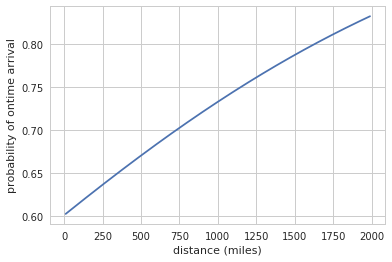

In [18]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

出発遅延時間固定

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


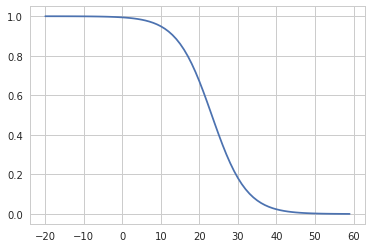

In [19]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
plt.plot(delay, prob)

タクシーアウト時間固定

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


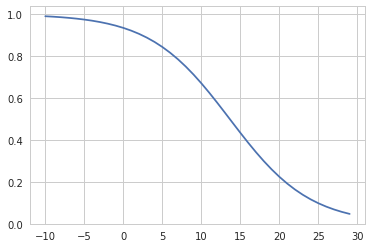

In [20]:
t_out = np.arange(-10, 30, 1)
prob = [lrmodel.predict([20, t, 500]) for t in t_out]
plt.plot(t_out, prob)

### モデルで予測する

モデルの保存

In [ ]:
MODEL_FILE

In [22]:
sc

<SparkContext master=yarn appName=pyspark-shell>

モデルのロード

In [23]:
from pyspark.mllib.classification import LogisticRegressionModel
LOAD_MODEL_FILE = 'gs://' + BUCKET + '/flights/sparkmloutput/model'
lrmodel = LogisticRegressionModel.load(sc, LOAD_MODEL_FILE)
# 閾値を0.7に設定
lrmodel.setThreshold(0.7)

In [24]:
print (lrmodel.predict([36.0, 12.0, 594.0]))

0


### モデルの評価

テストデータの作成
- 1部のデータにis_train_day = 'False'の日付のデータが入っていない場合があるので必要に応じてロードするcsv変更

In [25]:
# you may have to change this to find a shard that has test data
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)
flights_csv = spark.read\
            .schema(schema)\
            .csv(inputs)
# tmpビュー作成
flights_csv.createOrReplaceTempView('flights')

In [26]:
print(traindayquery)


select
  f.DEP_DELAY, f.TAXI_OUT, f.ARR_DELAY, f.DISTANCE
from flights f
join traindays t
on f.FL_DATE == t.FL_DATE
where
  t.is_train_day == 'True' and
  f.cancelled == '0.00' and
  f.diverted == '0.00'



In [27]:
testdayquery = traindayquery.replace(\
  "t.is_train_day == 'True'", "t.is_train_day == 'False'")
print(testdayquery)


select
  f.DEP_DELAY, f.TAXI_OUT, f.ARR_DELAY, f.DISTANCE
from flights f
join traindays t
on f.FL_DATE == t.FL_DATE
where
  t.is_train_day == 'False' and
  f.cancelled == '0.00' and
  f.diverted == '0.00'



In [36]:
def to_example(fields):
  return LabeledPoint(\
           float(fields['ARR_DELAY'] < 15), # on-time? \
           [\
             fields['DEP_DELAY'], \
             fields['TAXI_OUT'], \
             fields['DISTANCE'], \
           ])

testdata = spark.sql(testdayquery)
examples = testdata.rdd.map(to_example)

PythonRDD[111] at RDD at PythonRDD.scala:52

In [29]:
testdata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             12279|             12279|             12279|            12279|
|   mean| 15.13747047805196|16.429921003339032|10.809675054971903|888.1460216630019|
| stddev|45.245564391115856| 8.426630382956183|46.879360000828335|634.2444644273343|
|    min|             -39.0|               1.0|             -65.0|             31.0|
|    max|            1155.0|              94.0|            1142.0|           4983.0|
+-------+------------------+------------------+------------------+-----------------+



In [30]:
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))

In [54]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7
print (lrmodel.predict([6.0,12.0,594.0]))
print (lrmodel.predict([36.0,12.0,594.0]))

lrmodel.clearThreshold() # to make the model produce probabilities
# For dep_delay=20, taxiout=10 and distance=500, how does the distance affect prediction?
print (lrmodel.predict([20, 10, 500]))
print (lrmodel.predict([0, 10, 5000]))
print (lrmodel.predict([40, 10, 50]))

1
0
0.6703432230526639
0.9996063803828202
0.018195984376394483


Exampleから予測に必要な変数を取り出し、モデルが予測したラベルと、真のラベルを含むデータフレームを作成

In [48]:
# lp -> (label, predict)
# lp[0] -> Label(0 or 1)
# lp[1] -> 予測値(0~1)
def eval(labelpred):
    cancel = labelpred.filter(lambda lp: lp[1] < 0.7) # on-timeの確率が70%未満 -> キャンセル
    nocancel = labelpred.filter(lambda lp: lp[1] >= 0.7) # on-timeの確率が70%以上 -> ノンキャンセル
    corr_cancel = cancel.filter(lambda lp: lp[0] == int(lp[1] >= 0.7)).count() # lp[0]=0であるとの予測があたった数
    corr_nocancel = nocancel.filter(lambda lp: lp[0] == int(lp[1] >= 0.7)).count() # lp[0]=1であるとの予測があたった数
    
    cancel_denom = cancel.count() # キャンセルした数
    nocancel_denom = nocancel.count() # キャンセルしなった数
    
    # 0で割ることを防ぐ
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }  

In [50]:
# Evaluate model
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print ('All flights:')
print (eval(labelpred))

# keep only those examples near the decision threshold
print ('Flights near decision threshold:')
labelpred = labelpred.filter(lambda lp: lp[1] > 0.65 and lp[1] < 0.75)
print (eval(labelpred))

All flights:
{'total_cancel': 3390, 'total_noncancel': 8889, 'correct_cancel': 0.7772861356932154, 'correct_noncancel': 0.9363257959275509}
Flights near decision threshold:
{'total_cancel': 152, 'total_noncancel': 163, 'correct_cancel': 0.27631578947368424, 'correct_noncancel': 0.7361963190184049}


on-timeの確率が0.65~0.75と予測されたlabelpredのみを使用してevalすると予想通りcorrect_noncancel70%付近になっている